# Validation
Compare job counts between InteractionLayout, Lookahead routing with transpiled quantum circuit

In [1]:
from lib.interaction_mapping import InteractionMapping
from lib.interaction_layout import InteractionLayout
from lib.lookahead_routing import DynamicLookaheadSwap

In [2]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeLondonV2
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_embed_passmanager, generate_routing_passmanager
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, plot_histogram

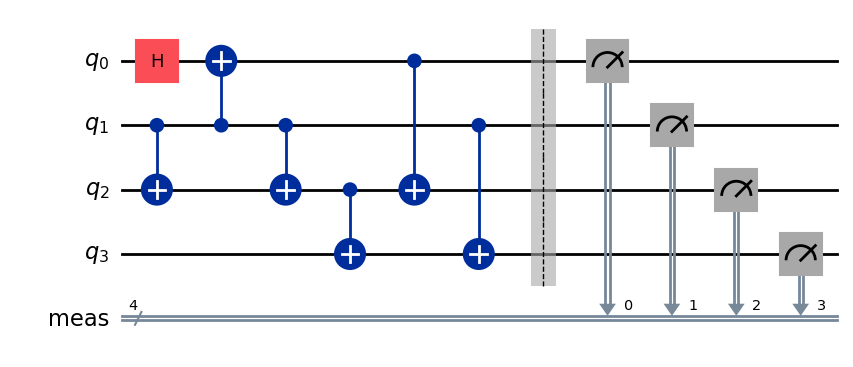

In [3]:
fake_backend = FakeLondonV2()

num_qubits = 4
qc = QuantumCircuit(num_qubits)
qc.h(0)
qc.cx(1, 2)

qc.cx(1, 0)
qc.cx(1, 2)
qc.cx(2, 3)

qc.cx(0, 2)
qc.cx(1, 3)

qc.measure_all()
display(qc.draw("mpl"))

dag = circuit_to_dag(qc)

In [4]:
interaction_mapping = InteractionMapping(
    coupling_map=fake_backend.coupling_map, dag=dag
)
best_layout = interaction_mapping.get_best_qpi_layout()
print("Best mapping layout:", best_layout)

Best mapping layout: [(1, 1), (2, 3), (0, 0), (3, 4)]


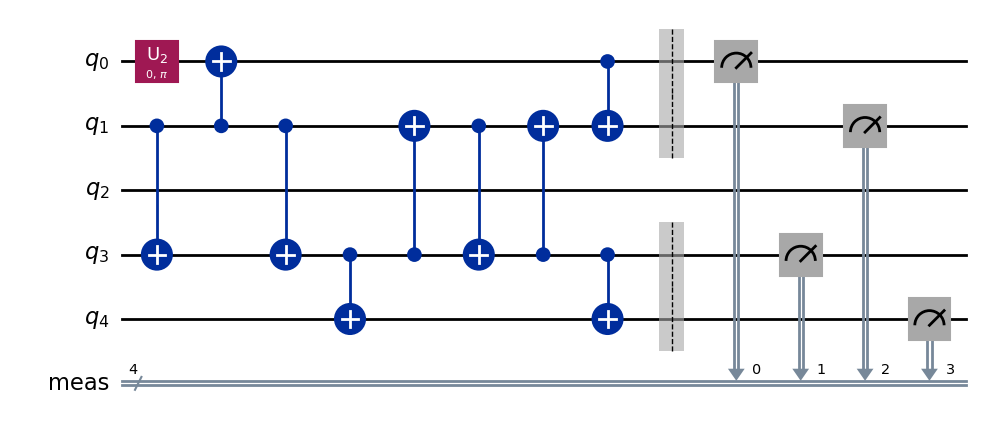

In [5]:
staged_pass = StagedPassManager()

staged_pass.layout = PassManager()
staged_pass.layout += InteractionLayout(
    coupling_map=fake_backend.coupling_map, initial_map=best_layout
)
staged_pass.layout += generate_embed_passmanager(fake_backend.coupling_map)
staged_pass.routing = generate_routing_passmanager(
    DynamicLookaheadSwap(fake_backend.coupling_map), target=fake_backend.coupling_map
)

routing_isa = staged_pass.run(qc).decompose()
display(routing_isa.draw("mpl"))

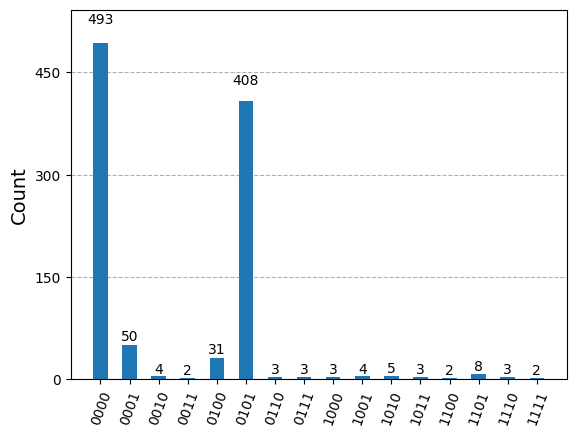

In [6]:
routing_job = fake_backend.run(routing_isa)
routing_counts = routing_job.result().get_counts()
plot_histogram(routing_counts)

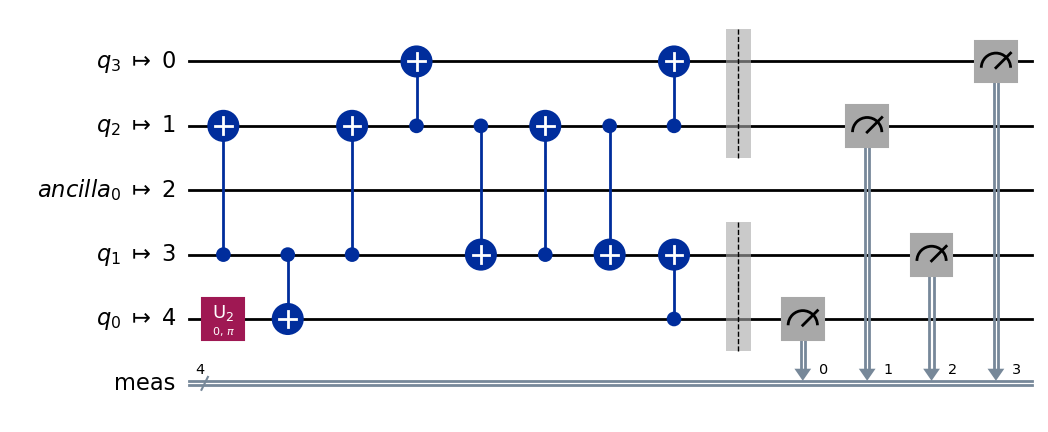

In [7]:
sabre_pass = generate_preset_pass_manager(
    optimization_level=0,
    backend=fake_backend,
    layout_method="sabre",
    routing_method="sabre",
)
sabre_isa = sabre_pass.run(qc)
display(sabre_isa.draw('mpl'))

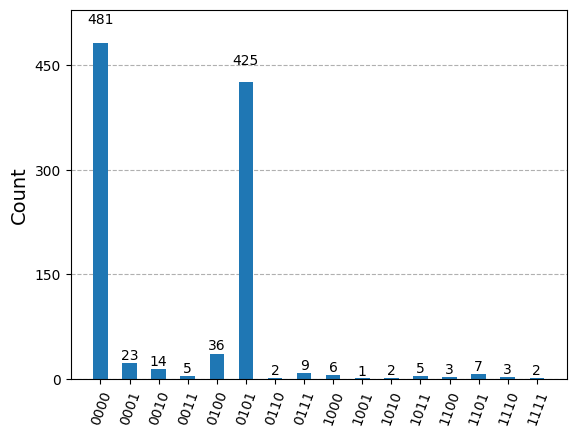

In [8]:
sabre_job = fake_backend.run(sabre_isa)
sabre_counts = sabre_job.result().get_counts()
plot_histogram(sabre_counts)

In [9]:
# Define a threshold for significant occurrence
# For example, here we use 10% of the maximum count as the threshold
def get_most_occurence(counts: dict, threshold_index: float = 0.7) -> list:
    threshold = threshold_index * max(counts.values())

    # Filter the keys based on the threshold
    significant_keys = [key for key, value in counts.items() if value > threshold]
    return significant_keys

In [10]:
# Print the significant keys
sig_routing_counts = get_most_occurence(routing_counts, 0.7)
sig_routing_counts.sort()
sig_sabre_counts = get_most_occurence(sabre_counts, 0.7)
sig_sabre_counts.sort()

print("Significant keys for transpiled counts:", sig_routing_counts)
print("Significant keys for random counts:", sig_sabre_counts)
print("Is the key same:", sig_routing_counts == sig_sabre_counts)

Significant keys for transpiled counts: ['0000', '0101']
Significant keys for random counts: ['0000', '0101']
Is the key same: True
